In [1]:
import requests
import pandas as pd
import numpy as np
import csv
from pathlib import Path

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
from os.path import exists

if not exists('../data/raw/popu.xlsx'):
    r = requests.get('https://www.abs.gov.au/statistics/people/population/regional-population/2021/32180DS0001_2001-21.xlsx',allow_redirects=True)
    open('../data/raw/population16-21.xlsx', 'wb').write(r.content)

if not exists('../data/raw/income14-19.xlsx'):
    r = requests.get('https://www.abs.gov.au/statistics/labour/earnings-and-working-conditions/personal-income-australia/2014-15-2018-19/6524055002_DO001.xlsx',allow_redirects=True)
    open('../data/raw/income14-19.xlsx', 'wb').write(r.content)


df = pd.read_excel('../data/raw/population16-21.xlsx', sheet_name='Table 1',header=7)  
# select Victoria data and modify column name
df = df.loc[df['S/T name'] == 'Victoria'][['SA2 code','no..15','no..16','no..17','no..18','no..19','no..20']]
df = df.rename(columns={'no..15': 2016, 'no..16': 2017,'no..17': 2018,'no..18': 2019,'no..19': 2020,'no..20': 2021})

dff = pd.read_excel('../data/raw/income14-19.xlsx', sheet_name='Table 1.4',header=6) 

# select Victoria data and modify column name

dff = dff.iloc[579:1041][['SA2','2014-15.4','2015-16.4','2016-17.4','2017-18.4','2018-19.4']]
dff = dff.rename(columns={'2014-15.4':'2014-15', '2015-16.4': '2015-16','2016-17.4': '2016-17','2017-18.4': '2017-18','2018-19.4': '2018-19'})

dff = dff.apply(pd.to_numeric, errors='coerce')


The population data from 2016 to 2021 is utilized to predict 2022 to 2025

There are three main factors that influence Australia population: fertility, mortality and migration. In the recent years, the most significant event is Covid-19, which the Australia population growth rate declines to 0.1 per cent from about 2 per cent from 2020 to 2021.

For fertility and mortality, before Covid, they contribute approximately 36 per cent of the population growth, which is 0.72 per cent. However, there is inconclusive evidence of excess mortality or changed fertility, so they are assumned to remain unchanged.

For migration, its number is greatly impacted by Covid. From the net overseas migration (NOM) forecast on the left graph, there are three lines of prediction, and we take the middle line: Seies B as our prediction baseline. We can see that until 2021, the annual NOM is about - 70,000, 0 until 2022, 70,000 until 2023, 130,000 until 2024 and 170,000 until 2025. Based on this, an approximate population trend on NOM is created on the right graph. 


<img src="../plots/NOMforecast.jpg" width=600 height=600 />

<img src="../plots/poputrend.png" width=800 height=600 />

link: https://mccrindle.com.au/article/topic/demographics/how-covid-19-is-likely-to-affect-australias-population-forecast/

However, the above model will only be applied to SA2 districts that are influenced by Covid. The criteria is, if population was increasing naturally before the Covid, the it declined after 2020, there is a high probability that the population loss is caused by Covid. Otherwise, the annual population increase will be the average of population increase over 2016 to 2021.





In [3]:


# natural growth rate without migration in Australia
mor_fer_rate = 1.0072

def predict22(row):  
    if row[2016] * mor_fer_rate * mor_fer_rate * mor_fer_rate * mor_fer_rate < row[2020] and row[2020] * mor_fer_rate > row[2021]:
        # have a high prob that this district is influenced by Covid
        return max(row[2021] * mor_fer_rate, 0) # NOM is 0, hence only count the mortality and fertility
    else:
        # have a high prob that this district is not very influenced by Covid
        return max((row[2021] - row[2016]) / 5 + row[2021], 0)

def predict23(row):  
    if row[2016] * mor_fer_rate * mor_fer_rate * mor_fer_rate * mor_fer_rate < row[2020] and row[2020] * mor_fer_rate > row[2021]:
        return max(row[2020] * mor_fer_rate * mor_fer_rate, 0) # annual increase of migrants until 2023 is offseted by the loss in 2021
    else:
        return max((row[2021] - row[2016]) / 5  + row[2022], 0)


def predict24(row):  
    if row[2016] * mor_fer_rate * mor_fer_rate * mor_fer_rate * mor_fer_rate < row[2020] and row[2020] * mor_fer_rate > row[2021]:
        return max(row[2023] * 1.0146, 0) # NOM is halfed compare to pre-Covid level in 2020, so growth rate in 2024 is 2% * 0.36 + 2% * 0.64 * 0.5 = 1.46%
    else:
        return max((row[2021] - row[2016]) / 5  + row[2023], 0)

def predict25(row):  
    if row[2016] * mor_fer_rate * mor_fer_rate * mor_fer_rate * mor_fer_rate < row[2020] and row[2020] * mor_fer_rate > row[2021]:
        return max(row[2023] * 1.0168, 0) # NOM is 3/4 compare to pre-Covid level in 2020, so growth rate in 2025 is 2% * 0.36 + 2% * 0.64 * 0.75 = 1.68%
    else:
        return max((row[2021] - row[2016]) / 5  + row[2024], 0)




df[2022] = df.apply(predict22, axis=1)
df[2023] = df.apply(predict23, axis=1)
df[2024] = df.apply(predict24, axis=1)
df[2025] = df.apply(predict25, axis=1)
df = df.astype({'SA2 code': 'int'})

filepath = Path('../data/curated/predictpopu.csv')  
df[['SA2 code',2022,2023,2024,2025]].to_csv(filepath, index=False)  





Income from 2014 to 2018 is utilized to predict 2019 to 2025

The approximate growth rate of wages until 2022 can be obtained from the graph below. The red dot points are the average weekly wages across the year. Weekly wages have the same trend with annual income, so it is safe to use this data.

<img src="../plots/weeklywage.jpg" width=800 height=600 />

link: https://tradingeconomics.com/australia/wages

It can be seem that before 2019, the enhancement was steady. There was a large increase of wages from 2019 to 2020, then in 2020, the speed of growth was even slower than 2013. From 2021 to 2022, the growth rate reached the peak over the past 10 years. 

From 2023 to 2025, according to Treasury forecast, growth rate is 2.4 per cent in 2022, and are forecasted to grow at this rate over the next few years, before slowing to 3.5 per cent in 2025-26. It can be estimated that the growth rate will be 2.8, 3.2, 3.6 for 2023, 2024 and 2025, which the average annual growth rate increases about 12.5 per cent. (0.4 / 3.2 = 0.125)

link: https://www.afr.com/policy/economy/real-wages-to-hit-12-year-low-as-inflation-predicted-to-surge-20220728-p5b5em#:~:text=Treasury%20forecasts%20nominal%20wages%20growth,instant%2C%E2%80%9D%20Dr%20Chalmers%20said.

All the SA2 districts will follow this model. Although some assumptions are comed up that districts with some specific features might have different income growth rate caused by Covid, such as empolyeement structure, tourist attractions, while as there is no official data about income according to SA2 after Covid-19 outbreaking, there is no way to prove the relationship between Covid and these features.



In [4]:
def rate(row): 
    if np.isnan(row['2018-19']):
        # entry is nan, no income in this district
        return 0
    else:
        if not np.isnan(row['2014-15']):
            # calculate growth rate over the past 4 years
            return (row['2018-19'] - row['2014-15']) / 4 / row['2018-19']
        else:
            # 2014 entry is nan, so use 2016 instead
            return (row ['2018-19'] - row ['2016-17']) / 2 / row['2018-19']

def predict2019(row):
    if np.isnan(row['2018-19']):
        # entry is nan
        return 0.0
    return max(float(row['2018-19']) * (1 + 1 * row['growthrate']),0) # steady growth

# is this two times the growth rate?
# also, do we need max(..., 0)?
def predict2020(row):
    return max(row['2019']* (1 + 2 * row['growthrate']),0) # fast growth
def predict2021(row):
    return max(row['2020']* (1 + 0.3 * row['growthrate']),0) # slow growth
def predict2022(row):
    return max(row['2021']* (1 + 2 * row['growthrate']),0) # fast growth
def predict2023(row):
    return max(row['2022']* (1 + (2 * row['growthrate']) * 1.13),0) # forecasted growth
def predict2024(row):
    return max(row['2023']* (1 + (2 * row['growthrate']) * 1.13 * 1.13),0) # forecasted growth
def predict2025(row):
    return max(row['2024']* (1 + (2 * row['growthrate']) * 1.13 * 1.13),0) # forecasted growth


dff['growthrate'] = dff.apply(rate, axis=1)
dff['2019'] = dff.apply(predict2019, axis=1)
dff['2020'] = dff.apply(predict2020, axis=1)
dff['2021'] = dff.apply(predict2021, axis=1)
dff['2022'] = dff.apply(predict2022, axis=1)
dff['2023'] = dff.apply(predict2023, axis=1)
dff['2024'] = dff.apply(predict2024, axis=1)
dff['2025'] = dff.apply(predict2025, axis=1)
filepath = Path('../data/curated/predictincome.csv')  
dff[['SA2','2019','2020','2021','2022','2023','2024','2025']].to_csv(filepath, index=False)

<BarContainer object of 12 artists>

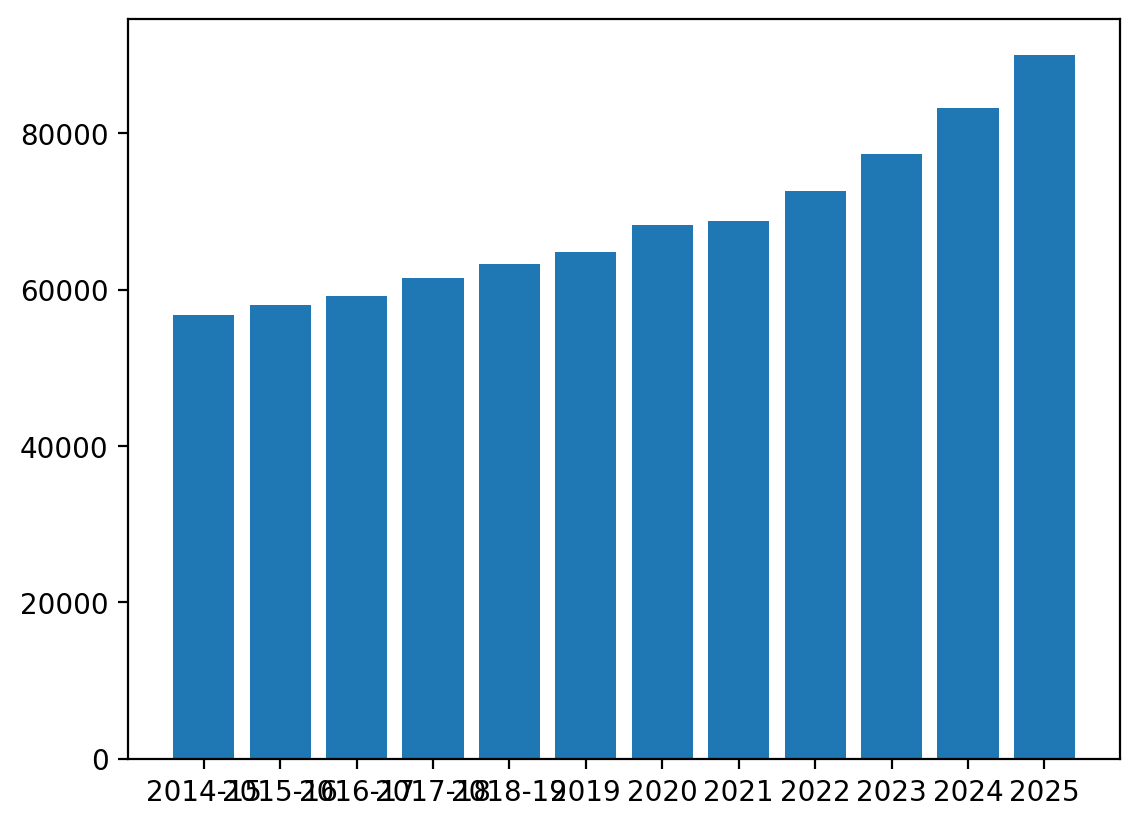

In [5]:
# I want to check to see if the predictions are reasonable

import matplotlib.pyplot as plt

years = list(set(dff.columns)-set(['SA2', 'growthrate']))
years.sort()

plt.rc('figure', dpi=200)

plt.bar(years, dff.mean()[years])

(array([ 1.,  1.,  0.,  1.,  1.,  0.,  0.,  2.,  5., 18., 33., 55., 72.,
        58., 63., 42., 20., 20., 14., 13., 13.,  6.,  2.,  8.,  3.,  3.,
         1.,  1.,  0.,  1.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([     0.        ,   5285.30277177,  10570.60554355,  15855.90831532,
         21141.21108709,  26426.51385887,  31711.81663064,  36997.11940241,
         42282.42217418,  47567.72494596,  52853.02771773,  58138.3304895 ,
         63423.63326128,  68708.93603305,  73994.23880482,  79279.5415766 ,
         84564.84434837,  89850.14712014,  95135.44989192, 100420.75266369,
        105706.05543546, 110991.35820724, 116276.66097

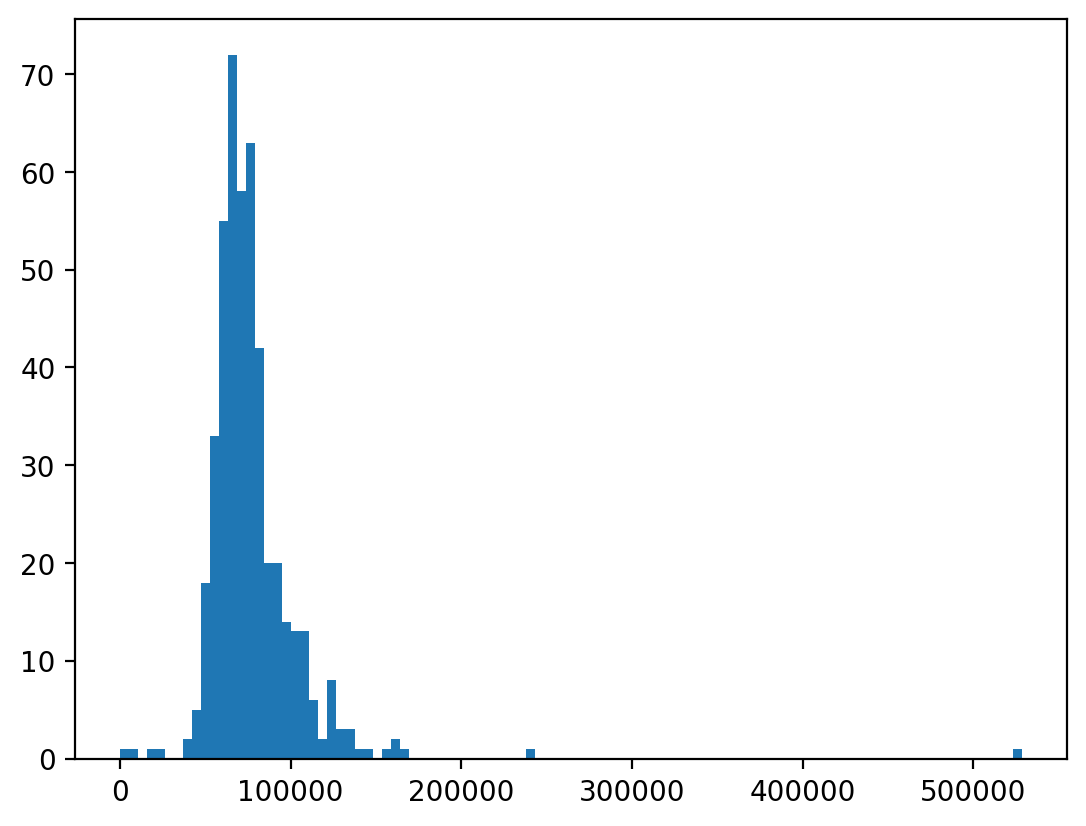

In [6]:
plt.hist(dff['2023'], bins=100)

In [7]:
# these are abit odd
dff[dff['2023'] < 30000]

,SA2,2014-15,2015-16,2016-17,2017-18,2018-19,growthrate,2019,2020,2021,2022,2023,2024,2025
658,205021080,NaN,NaN,23098.0,22659.0,23162.0,0.001382,23194.0,23258.088421,23267.728247,23332.020389,23404.871253,23487.449767,23570.319639
661,205021083,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
666,205031088,22726.0,32979.0,27364.0,32022.0,21230.0,-0.017617,20856.0,20121.177202,20014.837302,19309.651324,18540.867072,17706.727872,16910.115947
709,206051131,132566.0,224340.0,116157.0,87256.0,70348.0,-0.221108,54793.5,30562.946303,28535.633451,15916.724299,7963.075082,3466.602044,1509.131788
